In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from dask.distributed import Client, LocalCluster
from dask import delayed, compute
from dask import bag, array as da
%load_ext autoreload
%autoreload 2
%pylab inline

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bzr0014/anaconda3/envs/te

Populating the interactive namespace from numpy and matplotlib


In [2]:
from multiprocessing import Pool
pool = Pool(30)

Process ForkPoolWorker-22:
Process ForkPoolWorker-29:
Process ForkPoolWorker-16:
Process ForkPoolWorker-14:
Process ForkPoolWorker-21:
Traceback (most recent call last):
Process ForkPoolWorker-2:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-24:
Process ForkPoolWorker-27:
Process ForkPoolWorker-15:
Process ForkPoolWorker-19:
Process ForkPoolWorker-11:
Process ForkPoolWorker-23:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-20:
Process ForkPoolWorker-26:
Process ForkPoolWorker-6:
Process ForkPoolWorker-18:
Process ForkPoolWorker-28:
Process ForkPoolWorker-12:
Process ForkPoolWorker-30:
Process ForkPoolWorker-4:
Process ForkPoolWorker-25:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._arg

  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/multiprocessing/queues.py", line 334, in get
 

In [3]:
#cluster = LocalCluster(n_workers=30, threads_per_worker=1)

In [4]:
#client = Client(scheduler_file='/home/bzr0014/schedfile')
#client = Client(cluster)
#client.restart()

In [5]:
pylab.rcParams['figure.figsize'] = (10, 9)
def threshold(img, low, high, label):
    w, h, d = img.shape
    masks = []
    for i in range(3):
        masks.append(img[:, :, i] <= high[i])
        masks.append(img[:, :, i] >= low[i])
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones((w, h))
    for m in masks:
        mask *= m   
    return(mask * label)
def preprocess_label(label, shape):
    label = cv2.resize(label, shape)
    m1 = threshold(label, [0, 0, 0], [1, 1, 255], 1)
    m2 = threshold(label, [240, 0, 0], [255, 30, 255], 2)
    m3 = threshold(label, [255, 255, 255], [255, 255, 255], 3)
    #m4 = threshold(label, [0, 0, 240], [60, 255, 255], 4)
    m = m1 + m2 + m3 #+ m4
    m = cv2.erode(m, np.ones((3, 3)))
    return m

In [6]:
import joblib

In [13]:
B = {0, 5, 10, 15, 19, 20, 26, 29, 35, 37, 43, 45, 51, 55, 57, 60, 69, 73, 76, 82, 86, 90, 93, 99, 102,
 104, 107, 111, 113, 118, 121, 125, 128, 138, 141, 144, 151, 154, 156, 160, 164, 169, 178, 186, 188,
 192, 201, 206, 210, 214, 219, 221, 226, 230, 234, 237, 243, 249, 255, 257, 261, 267, 271, 272, 277, 280,
 285, 291, 295, 296, 310, 313, 319, 323, 325, 330, 332, 338, 343, 347, 349, 355, 358, 362, 366, 371, 374,
 376, 381, 386, 388, 393, 399, 405, 411, 413, 418, 420, 424, 431, 435, 439, 446, 448, 465, 467, 468, 472,
 476, 482, 484, 624, 633, 636, 640, 645, 650, 659, 663, 664, 669, 672, 678, 680, 684, 689, 693, 696, 702, 706,
 710, 712, 721, 724, 728, 731, 733, 739, 740, 747, 751, 752, 757, 762, 764, 769, 784, 791, 792, 794, 799, 811,
 813, 817, 826, 830}
miss_center = set(range(456, 624))
bad = {64, 68, 123, 139, 172, 175, 181, 217, 287, 340, 422, 428, 444, 447, 454, 460, 463, 464, 
       470, 473, 475, 486, 487, 488, 498, 630, 637, 694, 771, 804, 861}

In [14]:
A = B#set(range(832)) - (B | bad | miss_center)

In [15]:
_masked_images   = (joblib.load('cleaned_muscles.pkl'))
_raw_images = (joblib.load('raw_images.pkl'))
_original_images = (joblib.load('images.pkl'))
masked_images   = bag.from_sequence([_masked_images[i] for i in A])
raw_images   = bag.from_sequence([_raw_images[i] for i in A])
original_images = bag.from_sequence([_original_images[i] for i in A])
del _masked_images  
del _raw_images
del _original_images

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/dask/bag/core.py:2459: UserWarning: Insufficient elements for `take`. 20 elements requested, only 1 elements available. Try passing larger `npartitions` to `take`.
  "larger `npartitions` to `take`.".format(n, len(r))


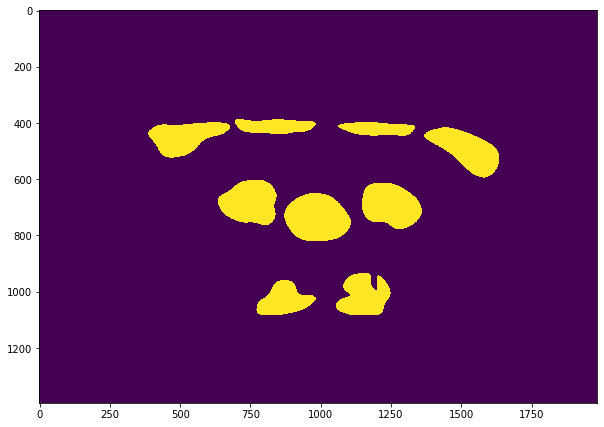

/home/bzr0014/anaconda3/envs/tensorGpu2/lib/python3.6/site-packages/dask/bag/core.py:2459: UserWarning: Insufficient elements for `take`. 20 elements requested, only 1 elements available. Try passing larger `npartitions` to `take`.
  "larger `npartitions` to `take`.".format(n, len(r))


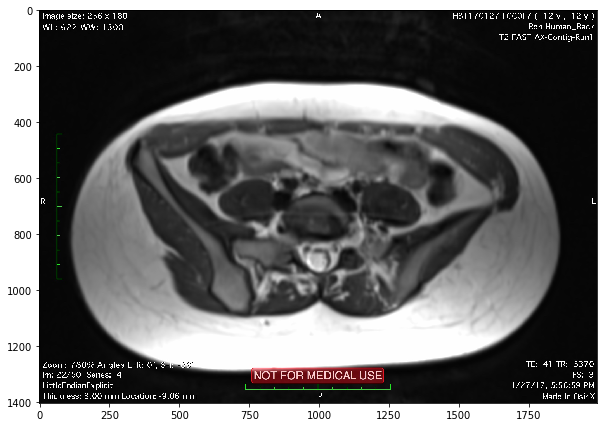

In [16]:
plt.imshow(masked_images.take(20)[0])
plt.show()
plt.imshow(raw_images.take(20)[0])

In [17]:
def resize_image(x, width):
    w, h, *_ = x.shape
    new_shape = h*width//w, width
    return cv2.resize(x, new_shape)

def resize_images(args, dsize):
    return tuple(cv2.resize(x, dsize) for x in args)


# 1. Setting mask margins to a certain value so they are never picked for training or test
def mark_margins(y, n_size):
    x = y.copy()
    m = n_size//2+1
    x[:m] = 255
    x[-m:] = 255
    x[:, :m] = 255
    x[:, -m:] = 255
    return x

# zooming in as much as possigle on the area of interes
# which is teh traced muscles
def crop_image(args, neigh_size):
    m = neigh_size//2
    x, y = args
    pts = np.where(y==1)
    w, h = y.shape
    x_mn = max(0, np.min(pts[0])-m)
    x_mx = min(w, np.max(pts[0])+m)
    y_mn = max(0, np.min(pts[1])-m)
    y_mx = min(h, np.max(pts[1])+m)
    #r = int((y_mx - y_mn)/(x_mx-x_mn) * resize)
    return x[x_mn:x_mx, y_mn:y_mx], y[x_mn:x_mx, y_mn:y_mx]

def normalize_image(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]
def get_shape_ratios(args):
    x, y = args
    r1 = x.shape[1]/x.shape[0]
    r2 = y.shape[1]/y.shape[0]
    return np.abs(r1-r2) < .01

In [18]:
def get_neighbors(xy, neigh_size, step):
    m = neigh_size//2
    if isinstance(xy, tuple):
        x, y = xy
        # change later
        x = (x-x.mean())/x.std()
        w, h, *_ = x.shape
        X = []
        Y = []
        for i in range(m, w-m, step):
            for j in range(m, h-m, step):
                X.append(x[i-m:i+m, j-m:j+m])
                Y.append(y[i, j])
        return np.array(X), np.array(Y)
    else:
        x = xy
        x = (x-x.mean())/x.std()
        w, h, *_ = x.shape
        X = []
        for i in range(m, w-m, step):
            for j in range(m, h-m, step):
                X.append(x[i-m:i+m, j-m:j+m])
        return np.array(X)

In [19]:
#PARAMS
dsize = resize_width, resize_height = 300, 300
neighSize = 17
STEP = 2

In [20]:
x = raw_images.map(lambda x: x[:, :, :1])
y = masked_images.map(lambda x: x-1)#.map(mark_margins, n_size=neighSize)

In [21]:
xy_ = bag.zip(x, y)\
    .filter(get_shape_ratios)\
    .map(resize_images, dsize=dsize)\
    .map(crop_image, neigh_size=neighSize)\
    .map(lambda x: (normalize_image(x[0]), x[1]))
xy = xy_.map(get_neighbors, neigh_size=neighSize, step=STEP)

In [22]:
import dask
from multiprocessing import Pool
with dask.config.set(pool=pool):
    XY = xy.compute()

In [23]:
XY[0][0].shape

(7050, 16, 16)

In [24]:
X = np.concatenate([x[0] for x in XY])
Y = np.concatenate([x[1] for x in XY])

In [25]:
preload = xy_.compute()

# Preparing sampling
At this point, let's just take random samples, in the future I can change this so I can decide what proportion of each label I want to pick; that is, setting a weight for each label.

*It is important to note that in order to make random kernel truly random, we need to explicitly pass the random seed to them. Otherwise the random states for all kernels (i.e. get_sample below) will have the same random states, leading to the same results on different runs.*

In [26]:
Y.shape

(1022414,)

# Next Step
XY is saved in `./cleaned_data.pkl`.

In [27]:
#pip install joblib

In [28]:
#joblib.dump((X, Y), 'cleaned_data2.pkl')

In [29]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import joblib
import numpy as np
import matplotlib.pyplot as plt
#X, Y = joblib.load('cleaned_data2.pkl')
#X = [x[0] for x in XY]
#Y = [x[1] for x in XY]

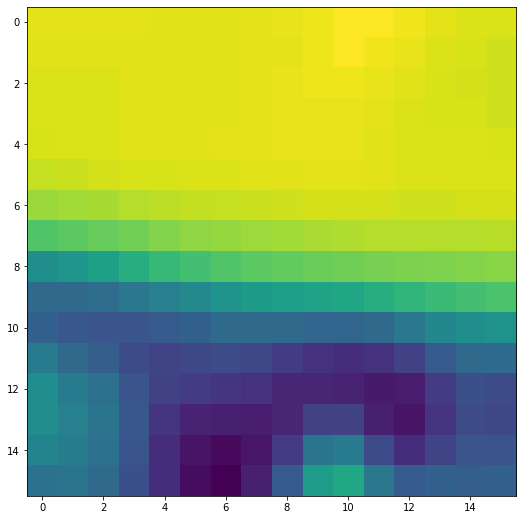

In [30]:
plt.imshow(X[156])

In [31]:
# keras important imports:
# import the necessary packages
from keras.models import Sequential
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


# Model v02

In [32]:
# Keras simple deep model:
def build_v02(width, height, depth, reg, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
        
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    #model.add(Conv2D(32, (10, 10), strides=(1, 1), padding="same",
    #    kernel_initializer=init,# kernel_regularizer=reg,
    #    input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv2D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv2D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(10, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    model.add(Activation("relu"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(10))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

# Model v03

In [33]:
# Keras simple deep model:
def build_v03(width, height, depth, reg, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
        
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    model.add(Conv2D(32, (30, 30), strides=(1, 1), padding="same",
        kernel_initializer=init,# kernel_regularizer=reg,
        input_shape=inputShape))
   
    model.add(Conv2D(32, (15, 15), strides=(1, 1), padding="same",
        kernel_initializer=init,# kernel_regularizer=reg,
        input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv2D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv2D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(10, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    model.add(Activation("relu"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    #model.add(Activation("relu"))
    #model.add(Flatten())
    #model.add(Dense(100))
    #model.add(Dense(10))
    #model.add(Dense(1))
    model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X.shape

(1022414, 16, 16)

In [36]:
*_, m, n = X.shape
#if len(_) == 1:
#    X = X.reshape(-1, m, n, 1)
#    Y = Y.reshape(-1, 1)

In [37]:
Xtr, Xts, Ytr, Yts = train_test_split(X.reshape(*X.shape, 1), Y.reshape(*Y.shape, 1)==1, test_size=.2)

In [38]:
from sklearn.preprocessing import StandardScaler

In [40]:
from keras import losses
# creating and starting keras model example:
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
#v02
#model = build(width=neighSize, height=neighSize, depth=1, reg=l2(0.0005))
model = build_v02(width=m, height=n, depth=1, reg=l2(0.0005))
model.compile(loss=losses.binary_crossentropy, optimizer=opt, metrics=["accuracy"])

In [41]:
1 - (Ytr.sum()/(Ytr>-1).sum())

0.7572729239997017

In [42]:
Xtr.shape

(817931, 16, 16, 1)

In [43]:
#model.fit(X, Y, batch_size=1)
# verion02
#model.fit_generator(gen(Xtr, Ytr, 10, neighSize), 1000, epochs=1000)#, validation_data=gen(Xts, Yts, 10, neighSize))
model.fit(Xtr, Ytr, batch_size=400, epochs=500)#, validation_data=gen(Xts, Yts, 10, neighSize))

Epoch 1/500
817931/817931 [==============================] - 74s 90us/step - loss: 0.3953 - acc: 0.8104
Epoch 2/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.3362 - acc: 0.8473
Epoch 3/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.3144 - acc: 0.8596
Epoch 4/500
817931/817931 [==============================] - 64s 79us/step - loss: 0.3007 - acc: 0.8668
Epoch 5/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.2903 - acc: 0.8720
Epoch 6/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.2824 - acc: 0.8766
Epoch 7/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.2755 - acc: 0.8796
Epoch 8/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.2699 - acc: 0.8828
Epoch 9/500
817931/817931 [==============================] - 65s 80us/step - loss: 0.2649 - acc: 0.8852
Epoch 10/500
817931/817931 [==============================] - 65

817931/817931 [==============================] - 64s 79us/step - loss: 0.1781 - acc: 0.9264
Epoch 80/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1777 - acc: 0.9262
Epoch 81/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1773 - acc: 0.9268
Epoch 82/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1768 - acc: 0.9265
Epoch 83/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1767 - acc: 0.9266
Epoch 84/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1759 - acc: 0.9269
Epoch 85/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1758 - acc: 0.9273
Epoch 86/500
817931/817931 [==============================] - 64s 79us/step - loss: 0.1758 - acc: 0.9272
Epoch 87/500
817931/817931 [==============================] - 65s 79us/step - loss: 0.1750 - acc: 0.9278
Epoch 88/500
817931/817931 [==============================] - 65s 79

KeyboardInterrupt: 

In [37]:
import datetime, re
d = re.sub(r':| |\.', '_', f"{datetime.datetime.now()}")
model.save(f'best_so_far_neighbor_{neighSize}_{d}.model_v02')

In [38]:
ls *v02

best_so_far_neighbor_17_2020-04-03_15_59_11_419756.model_v02
best_so_far_neighbor_21_2020-04-02_14_11_50_245698.model_v02
best_so_far_neighbor_41_2020-04-01_20_51_26_625740.model_v02
best_so_far_neighbor_41.model_v02


In [39]:
from keras.models import load_model
model = load_model(f'best_so_far_neighbor_17_2020-04-03_15_59_11_419756.model_v02')

In [59]:
from functools import reduce
def predict_image(x, model, neigh_size):
    m = neigh_size//2
    xn = get_neighbors(x, neigh_size, step=1)
    print(x.shape)
    m = neigh_size//2
    *_, w, h = tuple(x-2*m for x in x.shape)
    yn = model.predict(xn.reshape(*xn.shape, 1))
    print(w, h, w*h, yn.shape)
    return yn.reshape(w, h)

In [45]:
n = np.random.randint(len(preload))
print(n)
res = predict_image(preload[n][0], model, neighSize)

207
(124, 192)
108 176 19008 (19008, 1)


In [46]:
m = neighSize//2

TypeError: '>' not supported between instances of 'list' and 'float'

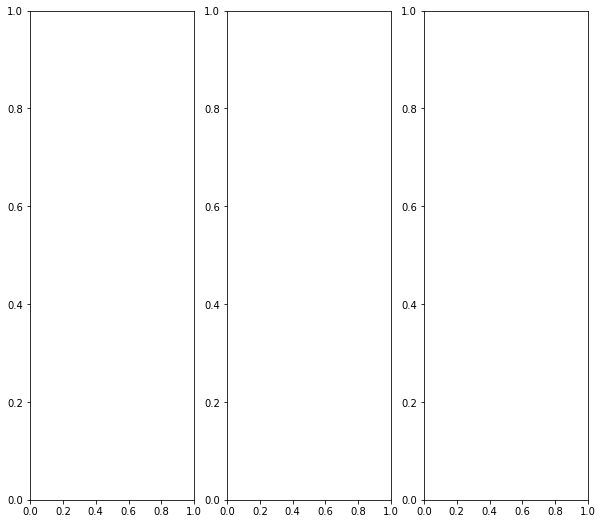

In [75]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(res>.9)
axes[1].imshow(preload[n][0])
axes[2].imshow(preload[n][1][m:-m, m:-m])

In [44]:
t = (preload[n][1][m:-m, m:-m] != (res>.5).astype('float')).sum()/(preload[n][1][m:-m, m:-m] == (res>.5).astype('float')).sum()
1/(1+t), t/(1+t), t

(0.9344262295081968, 0.06557377049180328, 0.07017543859649122)

In [60]:
x = [load_model(x) for x in """best_so_far_neighbor_17_2020-04-03_15_59_11_419756.model_v02 best_so_far_neighbor_21_2020-04-02_14_11_50_245698.model_v02 best_so_far_neighbor_41_2020-04-01_20_51_26_625740.model_v02"""\
    .split()]

In [61]:
models = {k: v for k, v in zip([17, 21, 41], x)}

In [62]:
n = np.random.randint(len(preload))
print(n)
x = preload[n][0]
res = [predict_image(x, model, neigh_size) for neigh_size, model in models.items()]

19
(191, 204)
175 188 32900 (32900, 1)
(191, 204)
171 184 31464 (31464, 1)
(191, 204)
151 164 24764 (24764, 1)


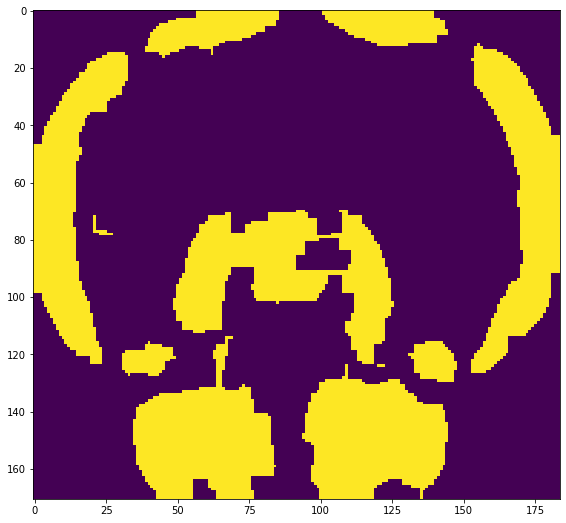

In [85]:
k = np.ones((5, 5))
plt.imshow(cv2.erode(cv2.dilate((res[1]>.95).astype('uint8'), k), k))

In [ ]:
axes[1].imshow(preload[n][0])

In [ ]:
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

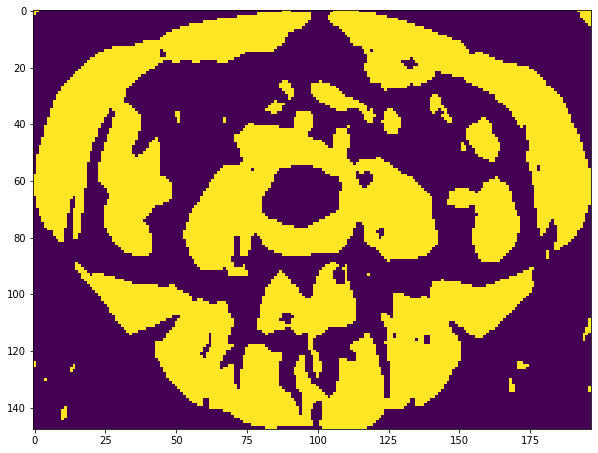

In [159]:
m = neighSize//2
#plt.imshow((res>.5)&(1-cv2.adaptiveThreshold(preload[n][0][m:-m, m:-m], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)))
plt.imshow((1-cv2.adaptiveThreshold(preload[n][0][m:-m, m:-m], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 10)))

In [473]:
Xts = (Xts - Xtr.mean())/Xtr.std()

In [474]:
Ypred = model.predict(Xts)

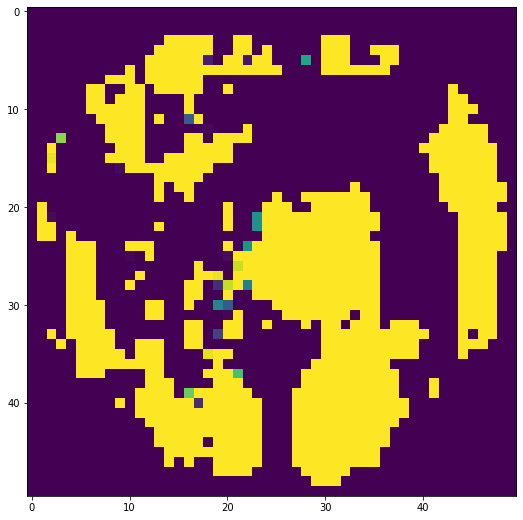

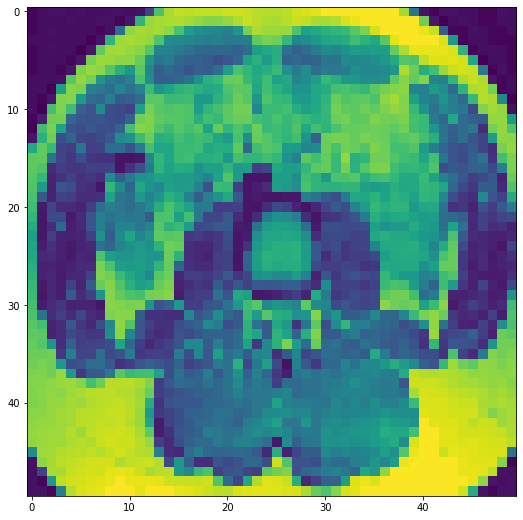

In [475]:
n = np.random.randint(len(Xts))
plt.imshow(Ypred[n, :, :, 0])
plt.show()
plt.imshow(Xts[n, :, :, 0])

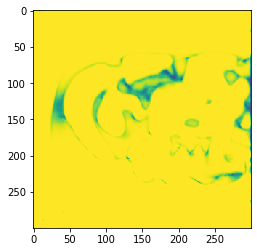

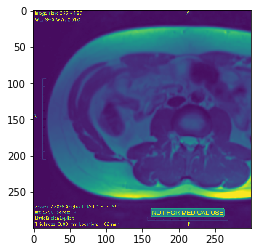

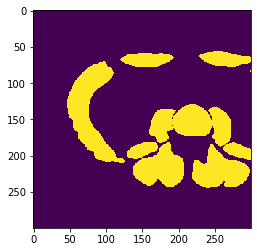

In [66]:
n=np.random.randint(len(Xtr))
plt.imshow(model.predict(Xtr[n:n+1])[0, :, :, 0])
plt.show()
plt.imshow(Xtr[n:n+1][0, :, :, 0])
plt.show()
plt.imshow(Ytr[n:n+1][0, :, :, 0]==1)

# Drafts

In [6]:
import psutil

In [8]:
psutil.virtual_memory()

svmem(total=1097116221440, available=1044705378304, percent=4.8, used=44512182272, free=638631673856, active=67704455168, inactive=368345939968, buffers=2365063168, cached=411607302144, shared=1370357760, slab=21075066880)

In [29]:
def get_sample(img_mask, size, n_size, seed):
    np.random.seed(seed)
    img, mask = img_mask
    m = n_size//2
    #nonzero = np.array(np.where(mask==1)).T
    nonzero = np.array(np.where(mask<255)).T
    #print(nonzero)
    #_4 = np.where(_2==0)
    _rands = np.random.randint(0, len(nonzero), size=size)
    chosen = nonzero[_rands]
    return np.array([img[x:x+n_size, y:y+n_size] for x,y in chosen-m]), mask[tuple(chosen.T)]
    #_random_indices1 = (_3[0][_rands], _3[1][_rands])
    #print(np.concat([_3[0]-m, _3[0]+m+1, _3[1])
#_rands = np.random.randint(len(_4[0]), size=10)
#_random_indices0 = (_4[0][_rands], _4[1][_rands])
_x, _y = get_sample((_1, _2), 10, neighSize, random.randint(0, 1000))
print(_y)

NameError: name 'random' is not defined

In [32]:
model.save('model_v02.pkl')

In [76]:
ls *v02

best_so_far_neighbor_41.model_v02


In [25]:
import tensorflow as tf

In [26]:
tf.test.is_gpu_available()

False

In [27]:
_X = tf.placeholder(dtype='float32', shape=[10])

In [68]:
len(X)

1524

In [144]:
images = raw_and_masked.persist()

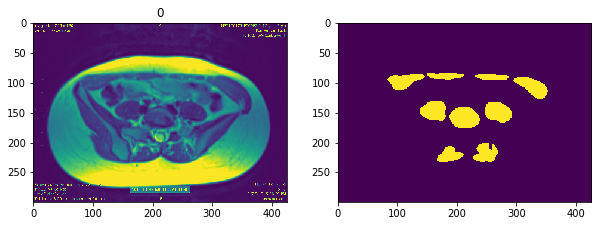

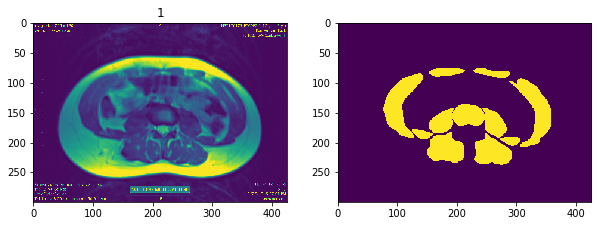

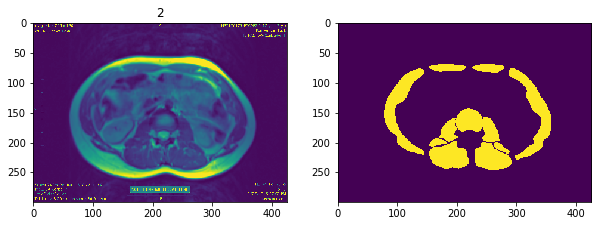

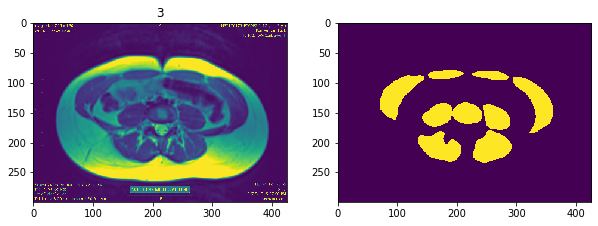

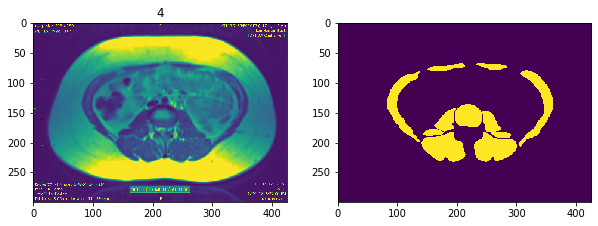

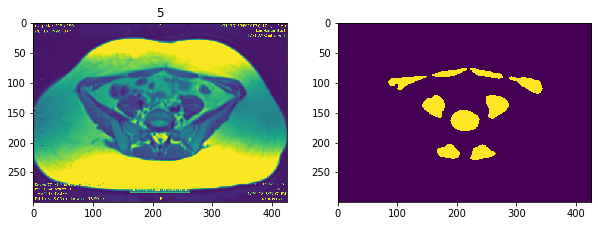

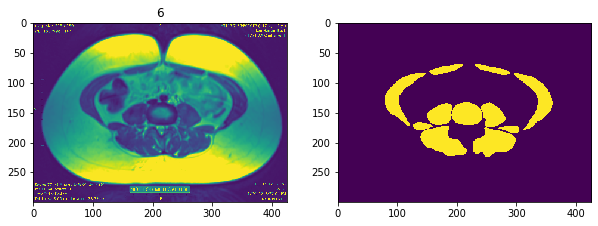

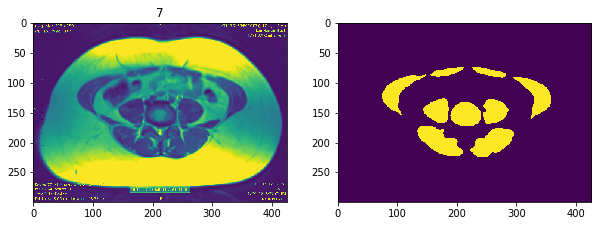

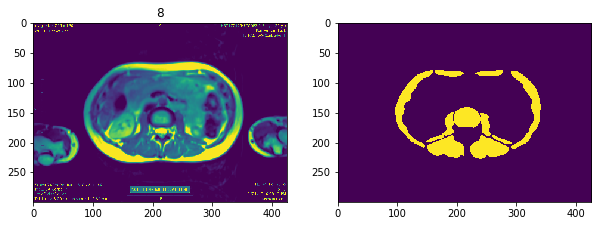

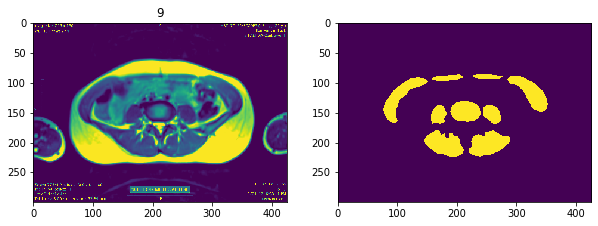

In [48]:
start = 0
n = 10
for i, (x, y) in enumerate(images[start:start+n], 0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(x[:,:,0])
    axes[1].imshow(y==1)
    axes[0].set_title(i)

In [167]:
new_images = raw_and_masked.map(_).compute()

In [168]:
#plt.imshow(images[701][0][:, :, 0])

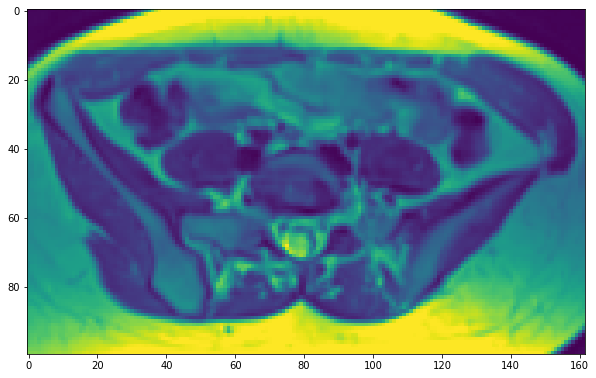

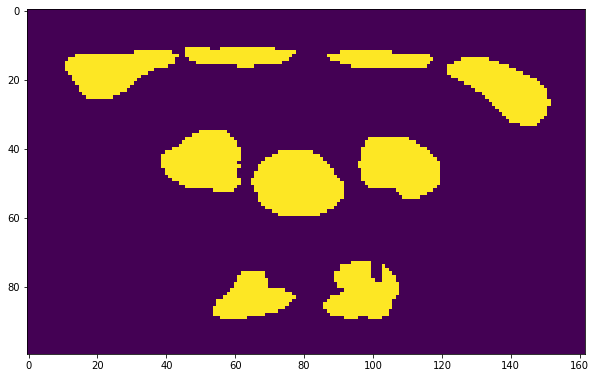

In [175]:
plt.imshow(new_images[0][0])
plt.show()
plt.imshow(new_images[0][1]==1)

In [159]:
new_images[0][1]

(189, 308)

In [2]:
import psutil

In [3]:
psutil.virtual_memory().percent

6.6

In [4]:
psutil.cpu_percent()

0.6